In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import polars as pl

import matplotlib.pyplot as plt

from torch import Tensor
from torch.optim import Optimizer
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import KFold

In [2]:
TIME_STEPS = 250
FACTORS = 10

We will look to learn a weight $w$ which is defined as $w = A \cdot \beta$ in the notation of the challenge.
This is sufficient to then construct $A$ and $\beta$ satisfying the challenge requirements.

# Data loading

Read the training data into a single tensor. We need to flip the data to have the time-steps in decreasing order, as this is how the factors are ordered in the definition of the factors on the challenge page.
We should have
$$ \hat{R}_{t+k+1} = (R_{t+k} \dots R_k) \cdot w, $$
where each $R_t$ is the column vector of returns at time $t$ and $\hat{R}_t$
is our prediction.

In [3]:
df = pl.read_csv("data/x_train.csv")
df = df.drop("stocksID")  # stocksID = row index

data = torch.tensor(df.to_numpy())  # => (stock, time)
data = data.type(torch.get_default_dtype())
data = data.flip(1)  # arrange time-steps in decreasing order

data.shape  # => (stock, time)

torch.Size([50, 754])

Create a dataset to load successively the windowed data.
One training example is one contiguous window of 251 days 
(250 days of input and 1 target day).

In [4]:
class WindowDataset(Dataset):
    def __init__(self, data: Tensor, input_len: int = TIME_STEPS):
        # TODO remove data duplication from unfold?

        self.windows = data.unfold(1, input_len + 1, step=1)  # => (stock, window, time)
        self.windows = self.windows.transpose(1, 0)  # => (window, stock, time)

    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        window = self.windows[index]  # => (stock, time)

        return window[:, 1:], window[:, :1]  # xs, ys => (stock, time)

    def __len__(self) -> int:
        return self.windows.shape[0]

# Auxiliary functions

Start by defining a function to evaluate a model on a dataset, with the challenge 
metric (average cosine similarity).

In [5]:
@torch.no_grad()
def evaluate_model(model: nn.Module, dataset: WindowDataset):
    # target is most recent time-step => (batch, stock, time)
    ys, xs = torch.split(dataset.windows, [1, TIME_STEPS], dim=-1)

    return F.cosine_similarity(model(xs), ys, dim=1).mean()

Next, we define the training loop for one epoch.
We simply optimise the weights to maximise cosine similarity (over a batch)
at each step.
We also scale the weight vector to always have norm one, as the metric is 
independent of the norm of the weight and we therefore avoid the norm becoming 
too large or too small.

In [6]:
def train_one_epoch(
    model: nn.Module, optimizer: Optimizer, dataset: Dataset, batch_size: int = 64
):
    for xs, ys in DataLoader(dataset, batch_size=batch_size, shuffle=True):
        # xs, ys => (batch, stock, time)

        objective = F.cosine_similarity(model(xs), ys, dim=1).mean()
        objective.backward()

        optimizer.step()
        optimizer.zero_grad()

        # normalise the weights after each step
        with torch.no_grad():
            model.weight.div_(torch.linalg.vector_norm(model.weight))

# Evaluation on average

We evaluate the model using cross-validation on the training data.

In [7]:
LR = 5e-4
EPOCHS = 250

kfold = KFold(5)

In [8]:
metrics = torch.zeros(2, kfold.get_n_splits(), EPOCHS)  # => (set, split, epoch)

for split, (train_idx, valid_idx) in enumerate(kfold.split(data.numpy())):
    train_dataset = WindowDataset(data[train_idx])
    valid_dataset = WindowDataset(data[valid_idx])

    model = nn.Linear(TIME_STEPS, 1, bias=False)
    optim = torch.optim.Adam(model.parameters(), lr=LR, maximize=True)

    for epoch in range(EPOCHS):
        train_one_epoch(model, optim, train_dataset)

        metrics[0, split, epoch] = evaluate_model(model, train_dataset)
        metrics[1, split, epoch] = evaluate_model(model, valid_dataset)

The average metrics (over the folds) are plotted below.

train: 0.1608 [+- 0.0062]
valid: 0.0470 [+- 0.0189]


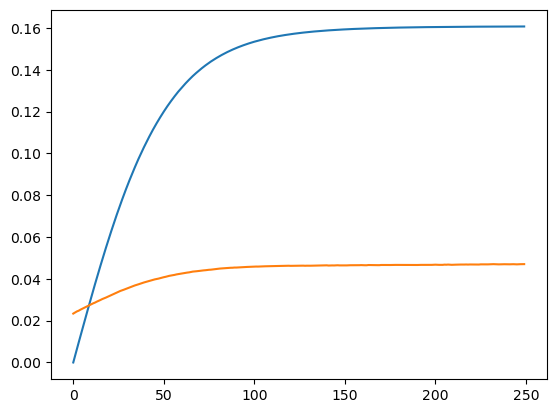

In [9]:
_mean, _std = metrics.mean(1).numpy(), metrics.std(1).numpy()

print(f"train: {_mean[0][-1]:.4f} [+- {_std[0][-1]:.4f}]")
print(f"valid: {_mean[1][-1]:.4f} [+- {_std[1][-1]:.4f}]")

plt.plot(np.arange(EPOCHS), _mean[0])
plt.plot(np.arange(EPOCHS), _mean[1])
plt.show()

The training and validation curves for each fold (paired by color) are as follows.
There is no large discrepency between the folds and the general shape of the 
curves mirrors that of the average.

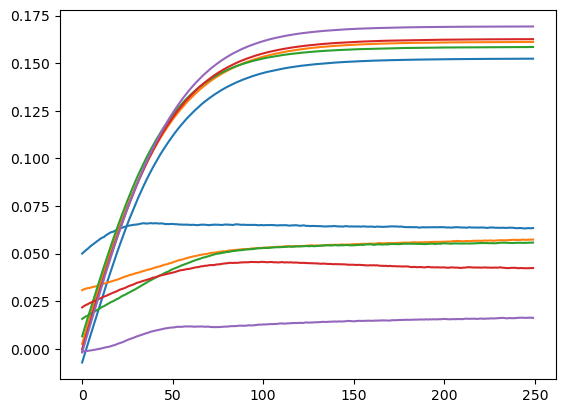

In [10]:
for split in range(kfold.get_n_splits()):
    plt.plot(np.arange(EPOCHS), metrics[0, split], color=f"C{split}")
    plt.plot(np.arange(EPOCHS), metrics[1, split], color=f"C{split}")

# Training

We now train the model on the entire dataset.

In [11]:
dataset = WindowDataset(data)

model = nn.Linear(TIME_STEPS, 1, bias=False)
optim = torch.optim.Adam(model.parameters(), lr=LR, maximize=True)

for epoch in range(EPOCHS):
    train_one_epoch(model, optim, dataset)

In [12]:
# extact weight vector from the model
weight = model.weight.clone().detach().T
weight.shape

torch.Size([250, 1])

# Submission

To prepare the submission, we need to construct the remaining nine factors.
The values do not matter as these will not be used for prediction, 
all we need to ensure is that the factors form an orthonormal set.
We achieve this by using QR decomposition on randomly generated factors.

We end up with a factors matrix $A = (A_1 \dots A_{10})$, where $A_1$ is the factor
learned above and $A_2, \dots, A_{10}$ are random vectors making $A$ orthogonal.
Choosing $\beta = (1, 0, \dots, 0)$ means that only $A_1$ is used for predictions,
thus recreating the model used in training.

In [13]:
matrix = torch.cat([weight, torch.randn(TIME_STEPS, FACTORS - 1)], dim=1)
matrix, r = torch.linalg.qr(matrix)

matrix[:, 0] *= torch.sign(r[0, 0])

assert torch.allclose(matrix[:, :1], weight)
assert torch.allclose(matrix.T @ matrix, torch.eye(matrix.shape[1]), rtol=0, atol=1e-6)

beta = torch.zeros(10)
beta[0] = 1

To prepare the submission, we stack the matrix $A$ and vector $\beta$.
The instructions on the challenge page are wrong, we need to stack the 
rows of $A$ (not the columns).

In [14]:
output = torch.cat([matrix.flatten(), beta])
output.shape

torch.Size([2510])

In [15]:
sub_df = pl.DataFrame(output).with_row_index()
sub_df.write_csv("submission.csv")